# Set up 

In [1]:
import tellurium as te
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import aesara.tensor as at
import aesara
floatX = aesara.config.floatX
import pymc as pm
import numpy as np

import cobra
import os

from scipy import stats
import scipy as sp
import math

import cloudpickle
import gzip

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
os.chdir('../../..')
from src import antemll, util
import emll
from emll.aesara_utils import LeastSquaresSolve
os.chdir('notebooks/topologyB/all_data/')

# Perturbing enzymes

In [3]:
ant ='../../../models/antimony/TopologyB.ant'
r = te.loada(ant)
r.conservedMoietyAnalysis = True
r.steadyState()

1.1363696703589205e-15

In [4]:
pt_levels = [0.5]
pt_labels = ['0.5x']

data_file05 = '../../../data/interim/generated_data/TopologyB-noReg/TopologyB_0.5.csv'

BMCA_obj05 = antemll.antemll(ant, data_file05, cobra_sbml='../../../models/sbml/TopologyB_cobra.xml')

prior05 = util.run_prior_predictive(BMCA_obj05)

No objective coefficients in model. Unclear what should be optimized


../../../models/antimony/TopologyB_cobra.ant


Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]


## Running ADVI

In [5]:
def run_ADVI(BMCA_obj, lr=5E-3, tgnc=0.7, onm=1):
    with pm.Model() as pymc_model:
        
        # Initialize elasticities
        Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BMCA_obj.Ex.to_numpy(), name='Ex'))
        Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BMCA_obj.Ey.to_numpy(), name='Ey'))
        e_obs = pm.Normal('e_obs', mu=1, sigma=10, observed=BMCA_obj.en.T)
        chi_obs = pm.Normal('chi_obs', mu=0, sigma=10, observed=BMCA_obj.xn.T)
        y_obs = pm.Normal('y_obs', mu=0, sigma=10, observed=BMCA_obj.yn.T)
        likelihood = pm.Deterministic('vn', e_obs * (np.ones(BMCA_obj.en.T.shape) + pm.math.dot(Ex_t,chi_obs) + pm.math.dot(Ey_t,y_obs)))
        v_hat_obs = pm.Normal('v_hat_obs', mu=likelihood, sigma=0.1, observed=BMCA_obj.vn.squeeze().T)
    
        N_ITERATIONS = 45000
    
    with pymc_model:
        advi = pm.ADVI()
        tracker = pm.callbacks.Tracker(
            mean = advi.approx.mean.eval,
            std = advi.approx.std.eval
        )
        approx = advi.fit(
            n=N_ITERATIONS, 
            callbacks = [tracker],
            obj_optimizer=pm.adagrad_window(learning_rate=lr), 
            total_grad_norm_constraint=tgnc,
            obj_n_mc=onm)
    
    with sns.plotting_context('notebook', font_scale=1.2):

        fig = plt.figure(figsize=(5,4))
        plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
        # plt.ylim([-1E1, 1E3])
        plt.xlim([0, N_ITERATIONS])
        sns.despine(trim=True, offset=10)

        plt.ylabel('-ELBO')
        plt.xlabel('Iteration')
        plt.title('in vitro ADVI convergence')
        plt.tight_layout()

    with pymc_model:
        trace = approx.sample(1000)
        ppc_vi = pm.sample_posterior_predictive(trace)

    return trace, ppc_vi


In [6]:
def run_FullRankADVI(BMCA_obj):
    with pm.Model() as pymc_model:
        
        # Initialize elasticities
        Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BMCA_obj.Ex.to_numpy(), name='Ex'))
        Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BMCA_obj.Ey.to_numpy(), name='Ey'))
        e_obs = pm.Normal('e_obs', mu=1, sigma=10, observed=BMCA_obj.en.T)
        chi_obs = pm.Normal('chi_obs', mu=0, sigma=10, observed=BMCA_obj.xn.T)
        y_obs = pm.Normal('y_obs', mu=0, sigma=10, observed=BMCA_obj.yn.T)
        likelihood = pm.Deterministic('vn', e_obs * (np.ones(BMCA_obj.en.T.shape) + pm.math.dot(Ex_t,chi_obs) + pm.math.dot(Ey_t,y_obs)))
        v_hat_obs = pm.Normal('v_hat_obs', mu=likelihood, sigma=0.1, observed=BMCA_obj.vn.squeeze().T)
    
        N_ITERATIONS = 45000
    
    with pymc_model:
        advi = pm.FullRankADVI()
        tracker = pm.callbacks.Tracker(
            mean = advi.approx.mean.eval,
            std = advi.approx.std.eval
        )
        approx = advi.fit(
            n=N_ITERATIONS, 
            callbacks = [tracker],
            obj_optimizer=pm.adagrad_window(learning_rate=5E-3), 
            total_grad_norm_constraint=0.7,
            obj_n_mc=1)
    
    with sns.plotting_context('notebook', font_scale=1.2):

        fig = plt.figure(figsize=(5,4))
        plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
        # plt.ylim([-1E1, 1E3])
        plt.xlim([0, N_ITERATIONS])
        sns.despine(trim=True, offset=10)

        plt.ylabel('-ELBO')
        plt.xlabel('Iteration')
        plt.title('in vitro ADVI convergence')
        plt.tight_layout()

    with pymc_model:
        trace = approx.sample(1000)
        ppc_vi = pm.sample_posterior_predictive(trace)

    return trace, ppc_vi


In [7]:
def try_except(run_ADVI, *params):
    try:
        return run_ADVI(*params)
    except:
        pass

c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 2,746.8
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 7,498
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 2,016.4
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 5,161.2
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 2,358.8
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 2,094.2
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 2,124.6
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,959.7
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 2,047.8
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 3,063.2
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 23,261
Sampling: [chi_obs, e_obs, v_hat_obs, y_obs]


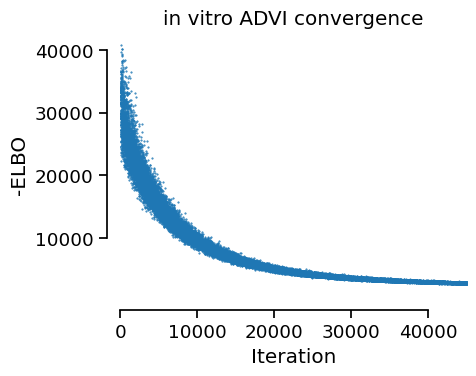

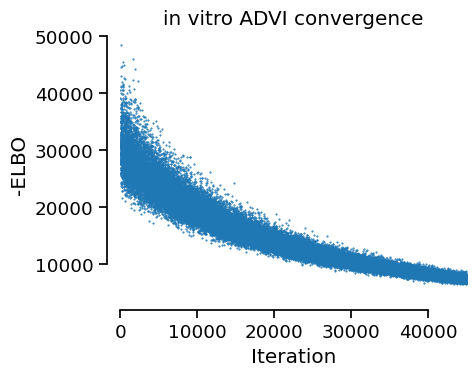

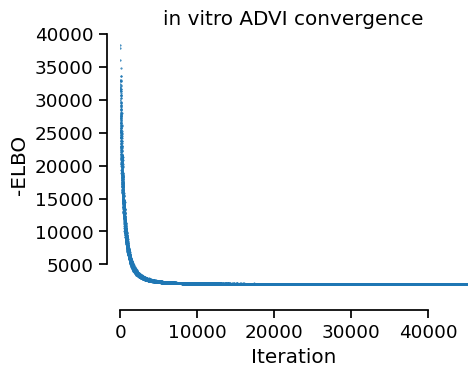

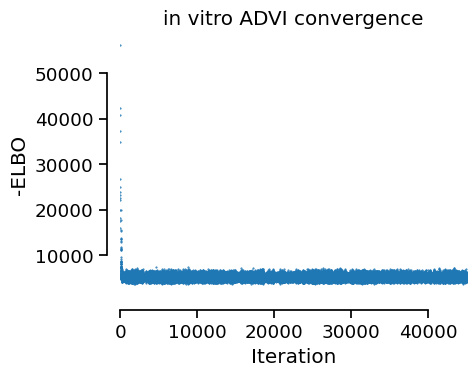

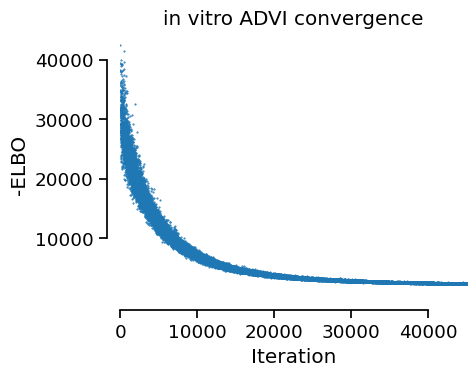

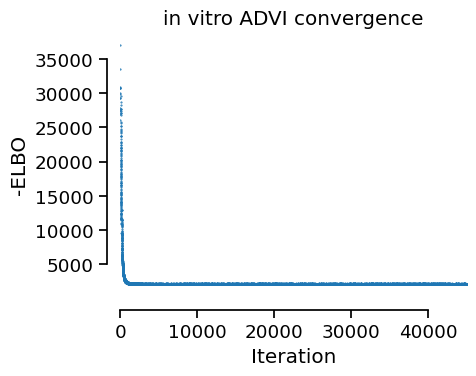

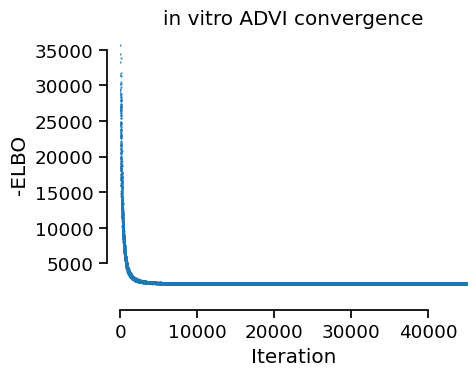

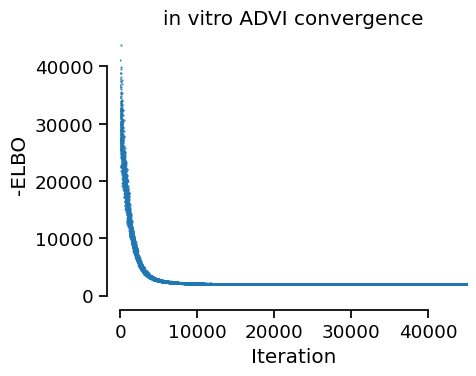

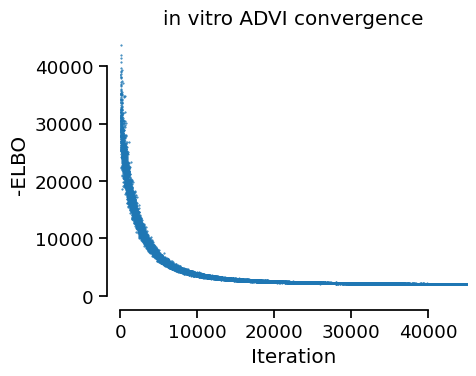

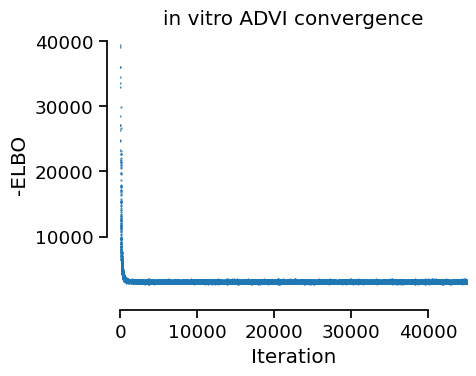

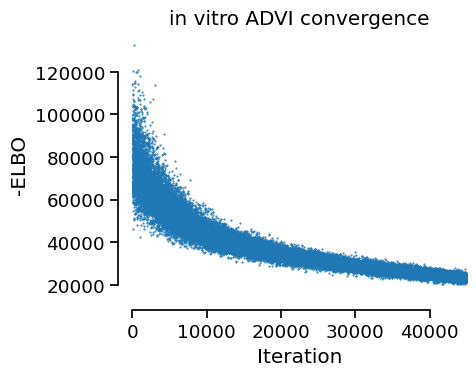

In [8]:
a05, aa05 = try_except(run_ADVI, BMCA_obj05)

b05, bb05 = try_except(run_ADVI, BMCA_obj05, 5E-3, 0.2)
c05, cc05 = try_except(run_ADVI, BMCA_obj05, 0.05, 1)
d05, dd05 = try_except(run_ADVI, BMCA_obj05, 0.5, 10)
e05, ee05 = try_except(run_ADVI, BMCA_obj05, 5E-3, 1)
f05, ff05 = try_except(run_ADVI, BMCA_obj05, 0.05, 10)
g05, gg05 = try_except(run_ADVI, BMCA_obj05, 0.5, 0.2)
h05, hh05 = try_except(run_ADVI, BMCA_obj05, 5E-3, 10)
i05, ii05 = try_except(run_ADVI, BMCA_obj05, 0.05, 0.2)
j05, jj05 = try_except(run_ADVI, BMCA_obj05, 0.5, 1)


k05, kk05 = try_except(run_FullRankADVI, BMCA_obj05)


In [9]:
single_var=[a05, b05, c05, d05, e05, f05, g05, h05, i05, j05, k05]
single_var_names=["a05", "b05", "c05", "d05", "e05", "f05", "g05", "h05", "i05", "j05", "k05"]
double_var=[aa05, bb05, cc05, dd05, ee05, ff05, gg05, hh05, ii05, jj05, kk05]
double_var_names=["aa05", "bb05", "cc05", "dd05", "ee05", "ff05", "gg05", "hh05", "ii05", "jj05", "kk05"]

In [10]:
jar = {}
for i, tr in enumerate(single_var):
    try: 
        jar[single_var_names[i]]=tr
        jar[double_var_names[i]]=double_var[i]
    except:
        pass


### saving trace data

In [11]:
with gzip.open("topologyB-noReg-hptuning05.pgz", "wb") as f:
            cloudpickle.dump(
                jar,
                f,
            )

# Analysis

In [5]:
picklefolder = '../../../data/results/tracePickles/'
with gzip.open(picklefolder + 'topologyB-noReg-hptuning05.pgz', "rb") as f:
    traces = cloudpickle.load(f, encoding='bytes')

In [6]:
a05 = traces['a05']
aa05 = traces['aa05']
b05 = traces['b05']
bb05 = traces['bb05']
c05 = traces['c05']
cc05 = traces['cc05']
d05 = traces['d05']
dd05 = traces['dd05']
e05 = traces['e05']
ee05 = traces['ee05']
f05 = traces['f05']
ff05 = traces['ff05']
g05 = traces['g05']
gg05 = traces['gg05']
h05 = traces['h05']
hh05 = traces['hh05']
i05 = traces['i05']
ii05 = traces['ii05']
j05 = traces['j05']
jj05 = traces['jj05']
k05 = traces['k05']
kk05 = traces['kk05']

In [7]:
single_var=[a05, b05, c05, d05, e05, f05, g05, h05, i05, j05, k05]
single_var_names=["a05", "b05", "c05", "d05", "e05", "f05", "g05", "h05", "i05", "j05", "k05"]
double_var=[aa05, bb05, cc05, dd05, ee05, ff05, gg05, hh05, ii05, jj05, kk05]
double_var_names=["aa05", "bb05", "cc05", "dd05", "ee05", "ff05", "gg05", "hh05", "ii05", "jj05", "kk05"]

In [8]:
v_ppc_aa05 = az.summary(aa05['posterior_predictive']['v_hat_obs'])['mean']
v_ppc_bb05 = az.summary(bb05['posterior_predictive']['v_hat_obs'])['mean']
v_ppc_cc05 = az.summary(cc05['posterior_predictive']['v_hat_obs'])['mean']
v_ppc_dd05 = az.summary(dd05['posterior_predictive']['v_hat_obs'])['mean']
v_ppc_ee05 = az.summary(ee05['posterior_predictive']['v_hat_obs'])['mean']
v_ppc_ff05 = az.summary(ff05['posterior_predictive']['v_hat_obs'])['mean']
v_ppc_gg05 = az.summary(gg05['posterior_predictive']['v_hat_obs'])['mean']
v_ppc_hh05 = az.summary(hh05['posterior_predictive']['v_hat_obs'])['mean']
v_ppc_ii05 = az.summary(ii05['posterior_predictive']['v_hat_obs'])['mean']
v_ppc_jj05 = az.summary(jj05['posterior_predictive']['v_hat_obs'])['mean']


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: 

In [9]:
x_ppc_aa05 = az.summary(aa05['posterior_predictive']['chi_obs'])['mean']
x_ppc_bb05 = az.summary(bb05['posterior_predictive']['chi_obs'])['mean']
x_ppc_cc05 = az.summary(cc05['posterior_predictive']['chi_obs'])['mean']
x_ppc_dd05 = az.summary(dd05['posterior_predictive']['chi_obs'])['mean']
x_ppc_ee05 = az.summary(ee05['posterior_predictive']['chi_obs'])['mean']
x_ppc_ff05 = az.summary(ff05['posterior_predictive']['chi_obs'])['mean']
x_ppc_gg05 = az.summary(gg05['posterior_predictive']['chi_obs'])['mean']
x_ppc_hh05 = az.summary(hh05['posterior_predictive']['chi_obs'])['mean']
x_ppc_ii05 = az.summary(ii05['posterior_predictive']['chi_obs'])['mean']
x_ppc_jj05 = az.summary(jj05['posterior_predictive']['chi_obs'])['mean']


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


In [10]:
e_ppc_aa05 = az.summary(aa05['posterior_predictive']['e_obs'])['mean']
e_ppc_bb05 = az.summary(bb05['posterior_predictive']['e_obs'])['mean']
e_ppc_cc05 = az.summary(cc05['posterior_predictive']['e_obs'])['mean']
e_ppc_dd05 = az.summary(dd05['posterior_predictive']['e_obs'])['mean']
e_ppc_ee05 = az.summary(ee05['posterior_predictive']['e_obs'])['mean']
e_ppc_ff05 = az.summary(ff05['posterior_predictive']['e_obs'])['mean']
e_ppc_gg05 = az.summary(gg05['posterior_predictive']['e_obs'])['mean']
e_ppc_hh05 = az.summary(hh05['posterior_predictive']['e_obs'])['mean']
e_ppc_ii05 = az.summary(ii05['posterior_predictive']['e_obs'])['mean']
e_ppc_jj05 = az.summary(jj05['posterior_predictive']['e_obs'])['mean']


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: 

In [11]:
v_ppcs = [v_ppc_aa05, v_ppc_bb05, v_ppc_cc05, v_ppc_dd05, v_ppc_ee05, v_ppc_ff05, v_ppc_gg05, v_ppc_hh05, v_ppc_ii05, v_ppc_jj05]
x_ppcs = [x_ppc_aa05, x_ppc_bb05, x_ppc_cc05, x_ppc_dd05, x_ppc_ee05, x_ppc_ff05, x_ppc_gg05, x_ppc_hh05, x_ppc_ii05, x_ppc_jj05]
e_ppcs = [e_ppc_aa05, e_ppc_bb05, e_ppc_cc05, e_ppc_dd05, e_ppc_ee05, e_ppc_ff05, e_ppc_gg05, e_ppc_hh05, e_ppc_ii05, e_ppc_jj05]

In [12]:
for ppc in v_ppcs:
    print(np.sum(abs(BMCA_obj05.vn.values - ppc.values.reshape((19,-1)).T))/(20*19))


3.6277016821620274
4.199286040453519
4.455986787731049
4.87896717538837
3.8473876950179067
4.558808336715369
4.367727435782306
4.521011084968756
4.4078758276249435
4.349443566432103


In [13]:
for ppc in x_ppcs:
    print(np.sum(abs(BMCA_obj05.xn.values - ppc.values.reshape((13,-1)).T))/(20*13))


0.34710016106139713
0.3340914508608704
0.33336760153788275
0.35781044374380894
0.34428818399940014
0.34551742510048844
0.33715970553367114
0.32824585681522467
0.34975185698901173
0.33951178478357175


#### Known flux and metabolite concentrations check

Text(0.5, 0.98, 'BMCA on Topology B, 0.5x pt, allData')

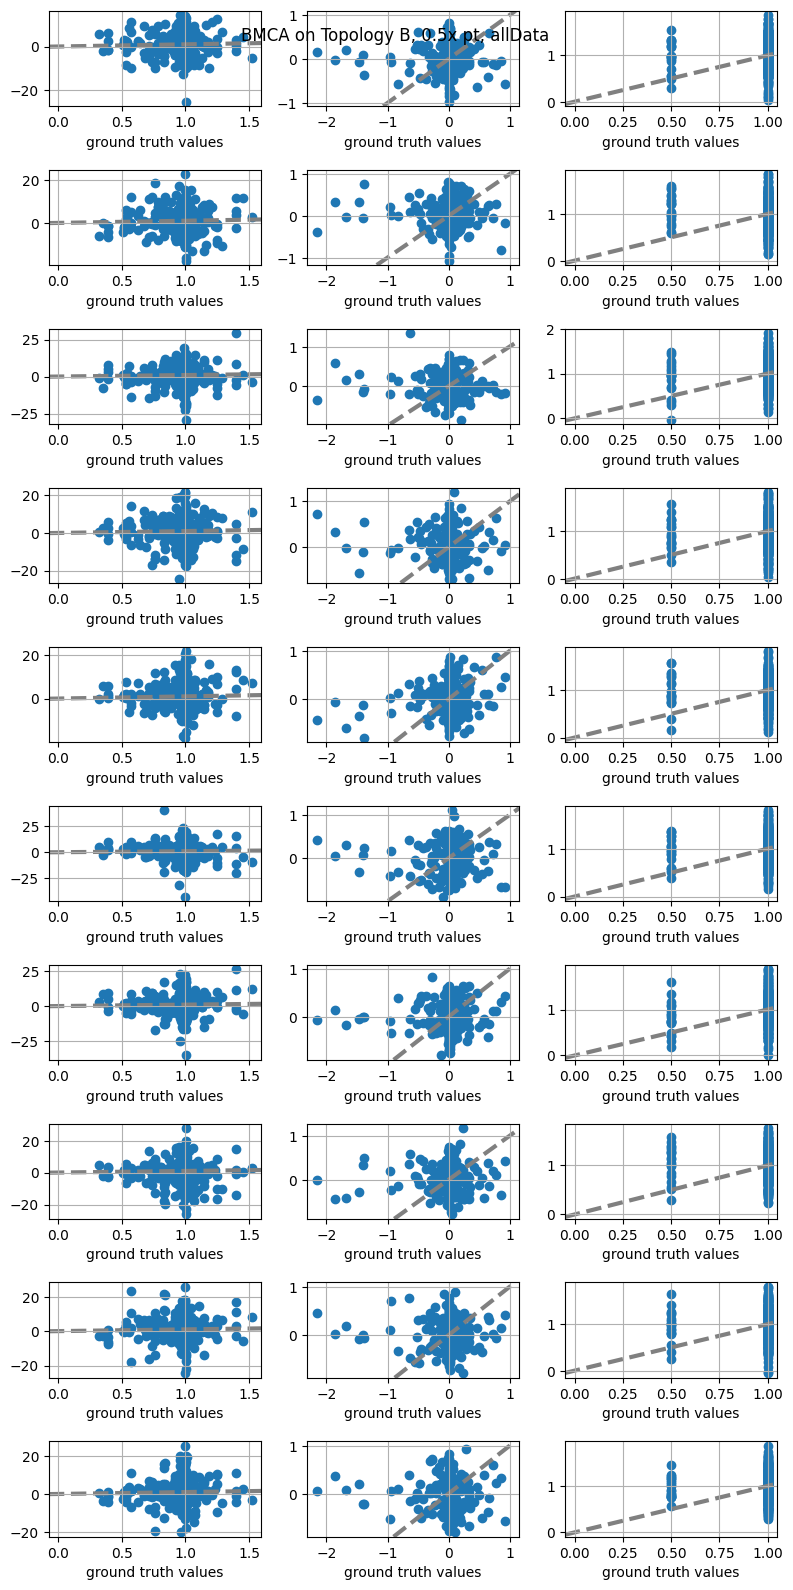

In [13]:
# Create two subplots and unpack the output array immediately
f, ax = plt.subplots(10, 3, figsize=(8,16))

for i in range(10):

    # ax[i,0].set_aspect('equal', 'datalim')
    ax[i,0].scatter(BMCA_obj05.vn.values, v_ppcs[i].values.reshape((19,-1)))
    ax[i,0].axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
    # ax[i,0].set_title('v_obs, ground truth vs. posterior predictive')
    ax[i,0].set_xlabel('ground truth values')
    # ax[i,0].set_ylabel('predicted values')
    ax[i,0].grid()

    # ax[i,1].set_aspect('equal', 'datalim')
    ax[i,1].scatter(BMCA_obj05.xn.values, x_ppcs[i].values.reshape((13,-1)))
    ax[i,1].axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
    # ax[i,1].set_title('chi_obs, ground truth vs. posterior predictive')
    ax[i,1].set_xlabel('ground truth values')
    ax[i,1].grid()

    # ax[i,2].set_aspect('equal', 'datalim')
    ax[i,2].scatter(BMCA_obj05.en.values, e_ppcs[i].values.reshape((19,-1)))
    ax[i,2].axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
    # ax[i,2].set_title('e_obs, ground truth vs. posterior predictive')
    ax[i,2].set_xlabel('ground truth values')
    ax[i,2].grid()

f.tight_layout()

f.suptitle('BMCA on Topology B, 0.5x pt, allData')

#### Elasticity check

In [14]:
Ex_a = util.get_az_summary(a05)
Ex_b = util.get_az_summary(b05)
Ex_c = util.get_az_summary(c05)
Ex_d = util.get_az_summary(d05)
Ex_e = util.get_az_summary(e05)
Ex_f = util.get_az_summary(f05)
Ex_g = util.get_az_summary(g05)
Ex_h = util.get_az_summary(h05)
Ex_i = util.get_az_summary(i05)
Ex_j = util.get_az_summary(j05)
Ex_k = util.get_az_summary(k05)


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: 

In [15]:
prior_Ex05_advi = az.summary(prior05['prior']['Ex'])['mean']

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


In [16]:
pt_labels= ['0.5x-pr'] + single_var_names

In [17]:
elasticity_values = np.column_stack([r.getScaledElasticityMatrix().flatten(),
                                prior_Ex05_advi, Ex_a,Ex_b, Ex_c, Ex_d, Ex_e, Ex_f, Ex_g, Ex_h, Ex_i, Ex_j, Ex_k])

elasticities_df = pd.DataFrame(elasticity_values, columns=['gt']+pt_labels,
                               index=[i + '_' + ii for i in r.getReactionIds() for ii in r.getFloatingSpeciesIds()])
# elasticities_df.to_csv('topologyB_allData_elasticities.csv')

In [18]:
e_slopes = [round(util.calculate_slope(elasticities_df['gt'], elasticities_df[i])[0],3) for i in pt_labels]
e_intercepts = [round(util.calculate_slope(elasticities_df['gt'], elasticities_df[i])[1],3) for i in pt_labels]
e_r2s = [round(util.calculate_slope(elasticities_df['gt'], elasticities_df[i])[2],3) for i in pt_labels]

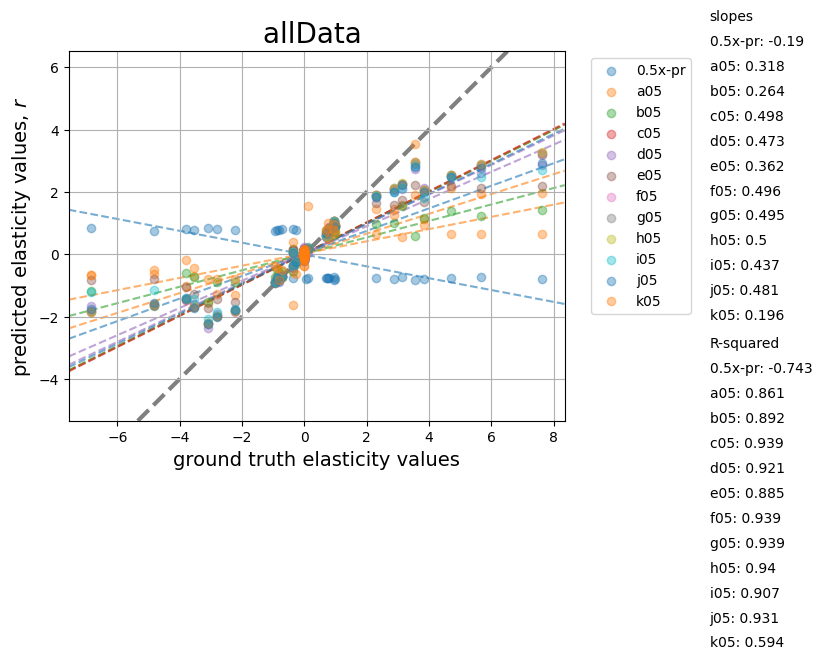

In [45]:
## Elasticities, comparison of prior and post 
#plt.ylim(-10,10)
#plt.xlim(-10,10)
plt.axes().set_aspect('equal', 'datalim')

for label in pt_labels: 
    plt.scatter(elasticities_df['gt'], elasticities_df[label], alpha=0.4, label=label, zorder=10)


plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth elasticity values', size=14)
plt.ylabel('predicted elasticity values, $\it{r}$', size=14)
# plt.title('Parity plot of elasticity values for various \nenzyme perturbation strengths—CRISPRi', size=20)
plt.title('allData ', size=20)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

left_adjust = 13
line_spacing = 0.8
slope_start = 7.5
r2_start = -3# slope_start-(7*line_spacing)

plt.text(left_adjust, slope_start, "slopes")
for i, label in enumerate(pt_labels):
    plt.text(left_adjust, (slope_start-line_spacing)-(i*line_spacing), f'{label}: {e_slopes[i]}')

plt.text(left_adjust, r2_start, 'R-squared')
for i, label in enumerate(pt_labels):
    plt.text(left_adjust, (r2_start-line_spacing)-(i*line_spacing), f'{label}: {e_r2s[i]}')

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']*3
for i in range(len(e_intercepts)):
    plt.axline((0, e_intercepts[i]), slope=e_slopes[i], linestyle='--', alpha=0.6, color=colors[i], zorder=0)


In [20]:
# print out MAE for each perturbation strength
MAE = abs(elasticities_df.sub(elasticities_df['gt'], axis=0)).sum()/len(elasticities_df['gt'])
MAE

gt         0.000000
0.5x-pr    0.385524
a05        0.174175
b05        0.203882
c05        0.126858
d05        0.193180
e05        0.158985
f05        0.130075
g05        0.130956
h05        0.122037
i05        0.137588
j05        0.159374
k05        0.253527
dtype: float64

## Calculating FCCs

In [21]:
gtFCC = pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), index=r.getReactionIds(), columns=r.getReactionIds())

### Negative predictions

In [22]:
Ex05_prior = util.get_az_summary(prior05['prior']['Ex'])


arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


In [23]:
priorFCC05 = util.estimate_CCs(BMCA_obj05, Ex05_prior.reshape((19,-1)))

postFCC_a05 = util.estimate_CCs(BMCA_obj05, Ex_a.reshape((19,-1)))
postFCC_b05 = util.estimate_CCs(BMCA_obj05, Ex_b.reshape((19,-1)))
postFCC_c05 = util.estimate_CCs(BMCA_obj05, Ex_c.reshape((19,-1)))
postFCC_d05 = util.estimate_CCs(BMCA_obj05, Ex_d.reshape((19,-1)))
postFCC_e05 = util.estimate_CCs(BMCA_obj05, Ex_e.reshape((19,-1)))
postFCC_f05 = util.estimate_CCs(BMCA_obj05, Ex_f.reshape((19,-1)))
postFCC_g05 = util.estimate_CCs(BMCA_obj05, Ex_g.reshape((19,-1)))
postFCC_h05 = util.estimate_CCs(BMCA_obj05, Ex_h.reshape((19,-1)))
postFCC_i05 = util.estimate_CCs(BMCA_obj05, Ex_i.reshape((19,-1)))
postFCC_j05 = util.estimate_CCs(BMCA_obj05, Ex_j.reshape((19,-1)))
postFCC_k05 = util.estimate_CCs(BMCA_obj05, Ex_k.reshape((19,-1)))

In [24]:
prior_FCCs = [priorFCC05]
post_FCCs = [postFCC_a05, postFCC_b05, postFCC_c05, postFCC_d05, postFCC_e05, postFCC_f05, postFCC_g05, postFCC_h05, postFCC_i05, postFCC_j05, postFCC_k05]


In [26]:
prd_priorFCCs = pd.concat([util.append_FCC_df(prior_FCCs[i], pt_labels[i], r) for i in range(len(prior_FCCs))])
prd_postFCCs = pd.concat([util.append_FCC_df(post_FCCs[i], pt_labels[i],r) for i in range(len(post_FCCs))])

## Evaluating FCC ranking

In [27]:
gtFCC=pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), columns=r.getReactionIds(), index=r.getReactionIds()).abs()
m1 = gtFCC.index.values[:, None] == gtFCC.columns.values
gtFCC = pd.DataFrame(np.select([m1], [float('Nan')], gtFCC), columns=gtFCC.columns, index=gtFCC.index)
gtFCC_rankings= gtFCC.rank(axis=1, ascending=False, na_option='keep')

a = gtFCC_rankings.loc['v19']

### via Spearman rank coefficients

In [28]:
spearman_coefficients = []
p_values = []
confidence_intervals = []
b_list = []
for FCC in prior_FCCs + post_FCCs:
    b = util.calculate_FCC_med_rankings(FCC, 'v19', r)
    b_list.append(b)
    spearman_r, p_value, lower_ci, upper_ci = util.bootstrap_spearman(a.dropna(), b.dropna())
    spearman_coefficients.append(spearman_r)
    p_values.append(p_value)
    confidence_intervals.append((lower_ci, upper_ci))


In [29]:
spearman_df = pd.DataFrame(spearman_coefficients, columns=['r'], index=pt_labels)
spearman_df['p-value'] = p_values
spearman_df['lower'] = [i[0] for i in confidence_intervals]
spearman_df['upper'] = [i[1] for i in confidence_intervals]
spearman_df

,r,p-value,lower,upper
0.5x-pr,0.180599,0.473289,-0.407294,0.681349
a05,0.428277,0.076201,-0.044213,0.777830
b05,0.477812,0.044912,-0.095748,0.858212
c05,0.869969,0.000003,0.564125,0.975169
d05,0.318885,0.197128,-0.165316,0.724884
e05,0.678019,0.001985,0.282157,0.899490
f05,0.779154,0.000138,0.457198,0.936590
g05,0.620227,0.006032,0.218691,0.872366
h05,0.880289,0.000001,0.667937,0.964211
i05,0.469556,0.049293,-0.089922,0.835559


In [30]:
# spearman_df.to_csv('../../../data/results/spearman_coefficients/topologyB-noReg-hptuning05_spr.csv')


(0.0, 1.05)

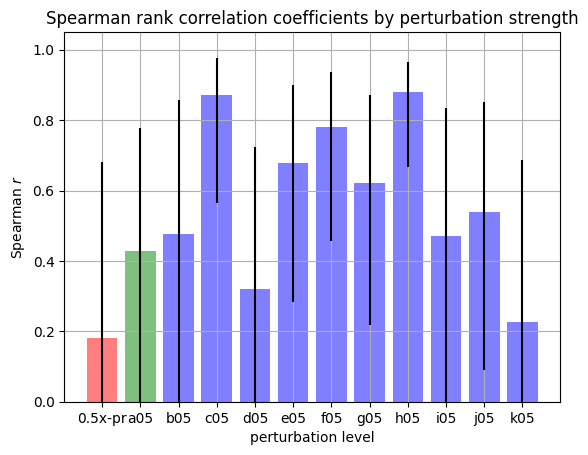

In [34]:
plt.bar(pt_labels, [i for i in spearman_coefficients], alpha=0.5, color=['r']+['g']+['b']*10 )
plt.grid()

for i, txt in enumerate(spearman_df['r']):
    plt.vlines(pt_labels[i], spearman_df['lower'][i], spearman_df['upper'][i], color='k')

plt.title("Spearman rank correlation coefficients by perturbation strength")
plt.xlabel('perturbation level')
plt.ylabel('Spearman $\it{r}$')
plt.ylim((0, 1.05))

### evaluating top 10 rankings

In [36]:
b_list = []
for FCC in prior_FCCs + post_FCCs:
    b = util.calculate_FCC_med_rankings(FCC,'v19',r)
    b_list.append(b)

ranked_b_list = [b.sort_values().reset_index().set_index('v19') for b in b_list]
q = pd.concat(ranked_b_list, axis=1)
q['gt'] = a.sort_values().reset_index().set_index('v19')
q.columns = pt_labels + ['gt']
q = q[['gt'] + pt_labels]
q.head(15) ## top 15 table

,gt,0.5x-pr,a05,b05,c05,d05,e05,f05,g05,h05,i05,j05,k05
v19,,,,,,,,,,,,,
1.0,v18,v18,v18,v18,v18,v1,v18,v1,v1,v1,v18,v1,v18
2.0,v1,v16,v14,v14,v14,v7,v14,v12,v7,v18,v1,v7,v17
3.0,v14,v17,v8,v8,v7,v12,v8,v7,v12,v14,v3,v12,v16
4.0,v7,v14,v12,v17,v4,v3,v5,v18,v3,v7,v7,v4,v4
5.0,v4,v8,v13,v1,v1,v4,v13,v3,v18,v3,v2,v3,v14
6.0,v5,v15,v4,v7,v5,v9,v1,v14,v9,v5,v8,v5,v5
7.0,v12,v13,v16,v16,v11,v11,v12,v8,v2,v8,v14,v11,v12
8.0,v3,v4,v15,v13,v12,v2,v4,v9,v11,v12,v17,v6,v1
9.0,v9,v5,v5,v5,v8,v18,v7,v4,v4,v4,v9,v14,v10


In [37]:
q.to_csv('../../../data/results/rankings/topologyB-noReg-hptuning05_rankings.csv')

In [38]:
rank_df = pd.read_csv('../../../data/results/rankings/topologyB-noReg-hptuning05_rankings.csv')

In [39]:
topTen_df = rank_df[rank_df['v19'].isin([1,2,3,4,5,6,7,8,9,10])]

gt_t10_set = set(list(topTen_df['gt']))

t10_sets = []
for pt in pt_labels: 
    t10_sets.append(set(list(topTen_df[pt])))

t10_scores=[]
for i in t10_sets: 
    t10_scores.append(len(set.intersection(gt_t10_set, i)))

t10_results = pd.DataFrame((np.array(t10_scores)).reshape((len(pt_labels),-1)).T, 
             columns=pt_labels)
t10_results ## number of correct predictions of top 10 FCC values 

,0.5x-pr,a05,b05,c05,d05,e05,f05,g05,h05,i05,j05,k05
0,6,7,7,9,7,8,9,8,9,7,7,6


In [40]:
# difference
dif_list = []
for i in t10_sets: 
    dif_list.append(i.difference(gt_t10_set))

for i in dif_list: 
    print(rank_df['gt'].loc[lambda x: x.isin(i)].index)

Int64Index([10, 13, 14, 16], dtype='int64')
Int64Index([10, 13, 14], dtype='int64')
Int64Index([10, 14, 16], dtype='int64')
Int64Index([11], dtype='int64')
Int64Index([11, 13, 17], dtype='int64')
Int64Index([10, 16], dtype='int64')
Int64Index([11], dtype='int64')
Int64Index([11, 17], dtype='int64')
Int64Index([10], dtype='int64')
Int64Index([10, 16, 17], dtype='int64')
Int64Index([11, 15, 17], dtype='int64')
Int64Index([11, 12, 14, 16], dtype='int64')
